# Homework 03
## Keith Wampler
#### AI Tool Used: Gemini 2.5 Pro 

### Homework - Principal Component Analysis
The CDC Social Vulnerability Index (SVI) takes multiple differen population-level inputs (e.g., % of the population living in poverty, % of the population without health insurance) to identify particularly vulnerable counties. While the CDC SVI scores rely on adding up the percentiles of various characteristics, there are alternative indexes (e.g., University of South Carolina SoVI index) that use methods like PCA. Here, we are going to use the CDC SVI data to create an alternative index based on PCA.

1. The following variables are used in the SVI: 

EP_POV150, EP_UNEMP, EP_HBURD, EP_NOHSDP, EP_UNINSUR, EP_AGE65, EP_AGE17, EP_DISABL, EP_SNGPNT, EP_LIMENG, EP_MINRTY, EP_MUNIT, EP_MOBILE, EP_CROWD, EP_NOVEH, EP_GROUPQ, EP_NOINT

a. Subset the merged dataset to only include the variables above and look at the pattern of missing data. Are missing observations scattered throughout the data or are entire rows or columns missing?

| Variable | Definition | SVI Theme |
| :--- | :--- | :--- |
| **`EP_POV150`** | Percentage of persons below 150% poverty line | Socioeconomic Status |
| **`EP_UNEMP`** | Percentage of civilian (age 16+) unemployed | Socioeconomic Status |
| **`EP_HBURD`** | Percentage of households with high housing cost burden (>=30% of income) | Socioeconomic Status |
| **`EP_NOHSDP`** | Percentage of persons (age 25+) with no high school diploma | Socioeconomic Status |
| **`EP_UNINSUR`**| Percentage of civilian noninstitutionalized population with no health insurance | Socioeconomic Status |
| **`EP_AGE65`** | Percentage of persons aged 65 and older | Household Characteristics |
| **`EP_AGE17`** | Percentage of persons aged 17 and younger | Household Characteristics |
| **`EP_DISABL`** | Percentage of civilian noninstitutionalized population with a disability | Household Characteristics |
| **`EP_SNGPNT`** | Percentage of single-parent households | Household Characteristics |
| **`EP_LIMENG`** | Percentage of persons (age 5+) who speak English "less than well" | Racial & Ethnic Minority Status |
| **`EP_MINRTY`** | Percentage of persons in racial or ethnic minority groups | Racial & Ethnic Minority Status |
| **`EP_MUNIT`** | Percentage of housing units in multi-unit structures (10+ units) | Housing Type & Transportation |
| **`EP_MOBILE`** | Percentage of housing units that are mobile homes | Housing Type & Transportation |
| **`EP_CROWD`** | Percentage of occupied housing units that are crowded (>1 person per room) | Housing Type & Transportation |
| **`EP_NOVEH`** | Percentage of households with no vehicle available | Housing Type & Transportation |
| **`EP_GROUPQ`** | Percentage of persons living in group quarters | Housing Type & Transportation |
| **`EP_NOINT`** | Percentage of households with no internet access | Adjunct Variable (Not in SVI calculation) |

## Data Loading

In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Define the path to the dataset CSV file
DATA_CSV = "/Users/keith/Documents/code/Intro to ML 2025/data/processed/processed_data.csv"
# Read the CSV file into a pandas DataFrame, handling potential mixed data types with low_memory=False
df = pd.read_csv(DATA_CSV, low_memory=False)

# Define the list of Social Vulnerability Index (SVI) variable names to be used in the analysis
SVI_VARS = [
    "EP_POV150","EP_UNEMP","EP_HBURD","EP_NOHSDP","EP_UNINSUR","EP_AGE65","EP_AGE17",
    "EP_DISABL","EP_SNGPNT","EP_LIMENG","EP_MINRTY","EP_MUNIT","EP_MOBILE","EP_CROWD",
    "EP_NOVEH","EP_GROUPQ","EP_NOINT"
]

# Define potential identifier columns (FIPS, State, County, NRI_ID)
# Filter this list to include only columns actually present in the DataFrame 'df'
ID_COLS = [c for c in ["FIPS","STATE_x","COUNTY_x","NRI_ID"] if c in df.columns]

# Create a new DataFrame 'svi' containing only the identifier columns (if any exist) and the SVI variables
# If no ID_COLS are found in df, just select the SVI_VARS
svi = df[ID_COLS + SVI_VARS] if ID_COLS else df[SVI_VARS]

# Display the first 5 rows of the 'svi' DataFrame to inspect the data
svi.head()

,FIPS,STATE_x,COUNTY_x,NRI_ID,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,...,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,EP_NOINT
0,1001,Alabama,Autauga,C01001,20.2,2.8,19.7,9.6,7.4,15.6,...,16.4,5.6,0.4,27.4,3.9,15.6,1.4,4.0,0.9,10.9
1,1003,Alabama,Baldwin,C01003,18.3,3.4,23.2,8.4,9.3,21.2,...,13.9,4.2,0.8,17.7,16.6,10.2,1.9,2.3,1.5,10.9
2,1005,Alabama,Barbour,C01005,37.7,5.8,25.1,23.5,10.7,19.8,...,18.1,11.3,2.0,55.4,1.4,29.2,3.8,11.7,12.0,31.8
3,1007,Alabama,Bibb,C01007,29.0,8.7,23.2,21.1,8.4,16.8,...,19.6,7.2,0.3,25.8,2.7,30.6,1.3,7.5,6.4,20.2
4,1009,Alabama,Blount,C01009,22.9,6.0,19.4,18.2,10.2,18.3,...,17.0,5.3,2.2,14.3,0.9,23.9,2.3,4.8,1.0,16.9


## Missing Data

In [20]:
# Calculate the number of missing (NA) values for each column in SVI_VARS
# Sort the results in descending order to see which columns have the most missing values
miss_by_col = svi[SVI_VARS].isna().sum().sort_values(ascending=False)

# Calculate the total number of rows that contain at least one missing value across the SVI_VARS columns
rows_with_any_na = svi[SVI_VARS].isna().any(axis=1).sum()

# Calculate the total number of rows where *all* SVI_VARS columns are missing
rows_with_all_na = svi[SVI_VARS].isna().all(axis=1).sum()

# Print the total number of rows and columns (SVI_VARS only)
print(f"Rows: {len(svi)}")
print(f"Columns: {len(SVI_VARS)}")
# Print the number and percentage of rows with any missing SVI values
print(f"Rows with ANY NA: {rows_with_any_na} ({rows_with_any_na/len(svi):.2%})")
# Print the number and percentage of rows where all SVI values are missing
print(f"Rows with ALL NA: {rows_with_all_na} ({rows_with_all_na/len(svi):.2%})")

# Display the Series showing the count of missing values per SVI column
miss_by_col

Rows: 3240
Columns: 17
Rows with ANY NA: 96 (2.96%)
Rows with ALL NA: 96 (2.96%)


EP_POV150     96
EP_LIMENG     96
EP_GROUPQ     96
EP_NOVEH      96
EP_CROWD      96
EP_MOBILE     96
EP_MUNIT      96
EP_MINRTY     96
EP_SNGPNT     96
EP_UNEMP      96
EP_DISABL     96
EP_AGE17      96
EP_AGE65      96
EP_UNINSUR    96
EP_NOHSDP     96
EP_HBURD      96
EP_NOINT      96
dtype: int64

b. PCA cannot handle missing values by default. There are several options for handling missing data generally, including imputation, removing rows with missing data, or removing columns with missing data. Deal with the missing data in a way that makes sense for the pattern of missing data and the goals of the analysis. Explain why you made this decision. Note: How you handle this is specific to the missing data pattern and the goals of the analysis. For example, when entire rows or columns are missing, imputation may not be appropriate and dropping those rows or columns is usually the best option. Conversely, if you have a general missingness pattern where missing observations are scattered throughout the data, imputation is likely the best option.

## Resolve Missing Data

In [21]:
# Create a boolean mask 'mask_all_missing' where True indicates rows where all SVI_VARS are NA
mask_all_missing = svi[SVI_VARS].isna().all(axis=1)

# Create a cleaned DataFrame 'svi_clean' by selecting rows where 'mask_all_missing' is False (i.e., dropping rows missing all SVI values)
# .copy() is used to avoid SettingWithCopyWarning
svi_clean = svi.loc[~mask_all_missing].copy()

# Check if there are *any* remaining missing values in the SVI columns of the cleaned DataFrame
if svi_clean[SVI_VARS].isna().any().any():
    # If there are scattered missing values, initialize an imputer to fill them using the median strategy
    imputer = SimpleImputer(strategy="median")
    # Fit the imputer on the SVI columns and transform the data, filling missing values
    # Create a new DataFrame 'svi_imputed' with the imputed values, keeping original column names and index
    svi_imputed = pd.DataFrame(imputer.fit_transform(svi_clean[SVI_VARS]),
                               columns=SVI_VARS, index=svi_clean.index)
else:
    # If there are no missing values left after dropping rows, simply copy the SVI columns to 'svi_imputed'
    svi_imputed = svi_clean[SVI_VARS].copy()

# Print the number of rows that were dropped
print(f"Dropped {mask_all_missing.sum()} rows (all SVI missing)")

# Calculate and display descriptive statistics (count, mean, std, min, quartiles, max) for the imputed SVI data
# .T transposes the output for better readability
svi_imputed.describe().T

Dropped 96 rows (all SVI missing)


,count,mean,std,min,25%,50%,75%,max
EP_POV150,3144.0,23.954580,8.394533,2.6,18.0,23.00,28.900,66.6
EP_UNEMP,3144.0,4.951336,2.474412,0.0,3.4,4.70,6.000,32.0
EP_HBURD,3144.0,21.855153,5.087702,0.0,18.6,21.55,24.900,48.5
EP_NOHSDP,3144.0,11.646406,5.718239,0.3,7.5,10.45,14.700,66.7
EP_UNINSUR,3144.0,9.512945,5.081359,0.0,5.8,8.40,12.000,45.1
EP_AGE65,3144.0,19.703753,4.842100,2.9,16.6,19.30,22.200,57.9
EP_AGE17,3144.0,21.896724,3.537931,0.0,19.8,21.90,23.800,41.2
EP_DISABL,3144.0,16.185305,4.544692,4.5,12.9,15.70,18.900,41.2
EP_SNGPNT,3144.0,5.734606,2.421851,0.0,4.2,5.40,7.000,20.3
EP_LIMENG,3144.0,1.589440,2.635562,0.0,0.3,0.70,1.700,36.4


The analysis of missing data revealed that 96 counties were missing values for all 17 SVI variables used in this analysis. Because PCA cannot handle missing values , and imputation is inappropriate when entire rows of relevant data are missing , the most sensible approach was to drop these 96 rows entirely. This approach ensures that the PCA is performed only on counties with complete information for the SVI variables, maintaining the integrity of the analysis without introducing artificial data through imputation in cases of complete data absence.

## Run PCA

In [22]:
# Initialize a StandardScaler object to standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
# Fit the scaler to the imputed SVI data and transform it, resulting in a standardized NumPy array 'X'
X = scaler.fit_transform(svi_imputed)

# Initialize a PCA object
# n_components is set to the number of SVI variables to initially capture all possible components
# random_state ensures reproducibility
pca = PCA(n_components=len(SVI_VARS), random_state=42)
# Fit the PCA model to the standardized data 'X' and apply the dimensionality reduction
X_pca = pca.fit_transform(X)

# Get the proportion of variance explained by each principal component
explained = pca.explained_variance_ratio_
# Calculate the cumulative sum of the explained variance ratios
cum_explained = np.cumsum(explained)

# Create a pandas DataFrame to display the explained variance and cumulative explained variance for each PC
# Display the first 10 rows of this DataFrame
pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(explained))], # Column for PC names (PC1, PC2, ...)
    "Explained_Var": explained,                          # Column for individual explained variance
    "Cumulative": cum_explained                          # Column for cumulative explained variance
}).head(10)

,PC,Explained_Var,Cumulative
0,PC1,0.282259,0.282259
1,PC2,0.191706,0.473965
2,PC3,0.108279,0.582244
3,PC4,0.068032,0.650275
4,PC5,0.059289,0.709564
5,PC6,0.057202,0.766767
6,PC7,0.036447,0.803213
7,PC8,0.034255,0.837468
8,PC9,0.029524,0.866992
9,PC10,0.026252,0.893244


## PC Scree Plot

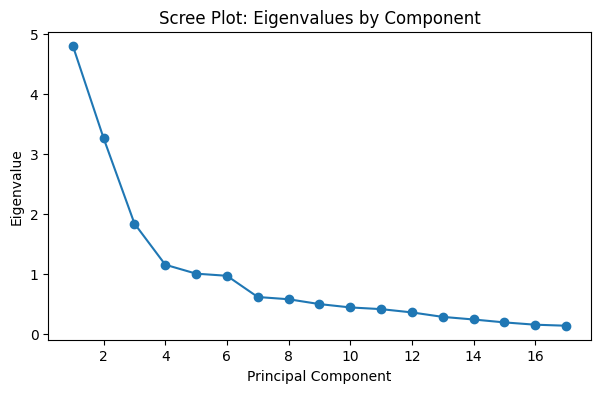

In [23]:
# Create a figure and axes for the plot with a specific size
plt.figure(figsize=(7,4))
# Plot the eigenvalues (explained variance) against the principal component number (1 to 17)
# 'marker='o'' adds points to the line plot
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='o')
# Set the title of the plot
plt.title("Scree Plot: Eigenvalues by Component")
# Label the x-axis
plt.xlabel("Principal Component")
# Label the y-axis
plt.ylabel("Eigenvalue")
# Display the plot
plt.show()

The scree plot shows the eigenvalues for each PC. There is a noticeable elbow after the third principal component which suggests that retaining the first three principal components might be appropriate, as they capture the most substantial portion of the variance before the contributions become more marginal. Retaining four could also be argued, depending on interpretation, but the drop-off is sharpest after PC3

## PCs Required for 80% / 90% Variance

In [24]:
# Find the index of the first cumulative explained variance value that is >= 0.80
# Add 1 because indices are 0-based, but PC numbers are 1-based
pcs_80 = np.argmax(cum_explained >= 0.80) + 1
# Find the index of the first cumulative explained variance value that is >= 0.90
# Add 1 for 1-based PC numbering
pcs_90 = np.argmax(cum_explained >= 0.90) + 1

# Print the number of principal components needed to explain at least 80% of the variance
print(f"PCs needed for 80% variance: {pcs_80}")
# Print the number of principal components needed to explain at least 90% of the variance
print(f"PCs needed for 90% variance: {pcs_90}")

PCs needed for 80% variance: 7
PCs needed for 90% variance: 11


## Loadings for PC1–PC3

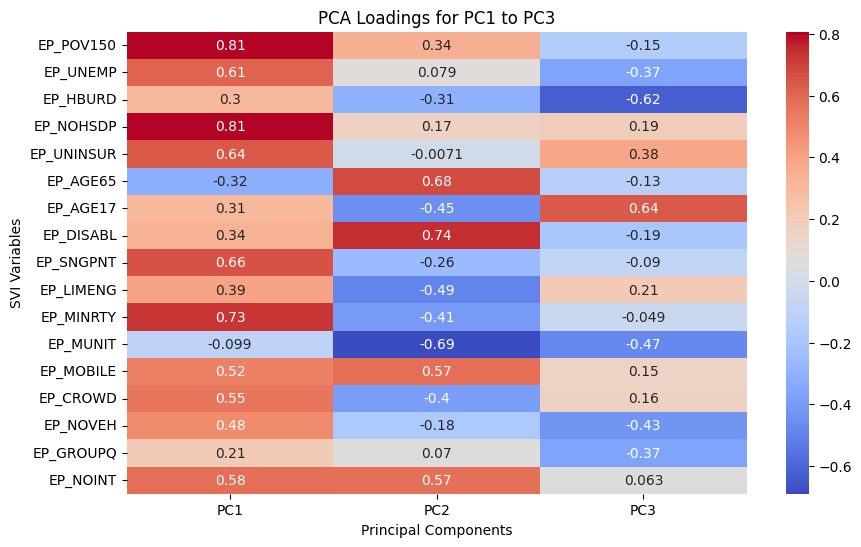

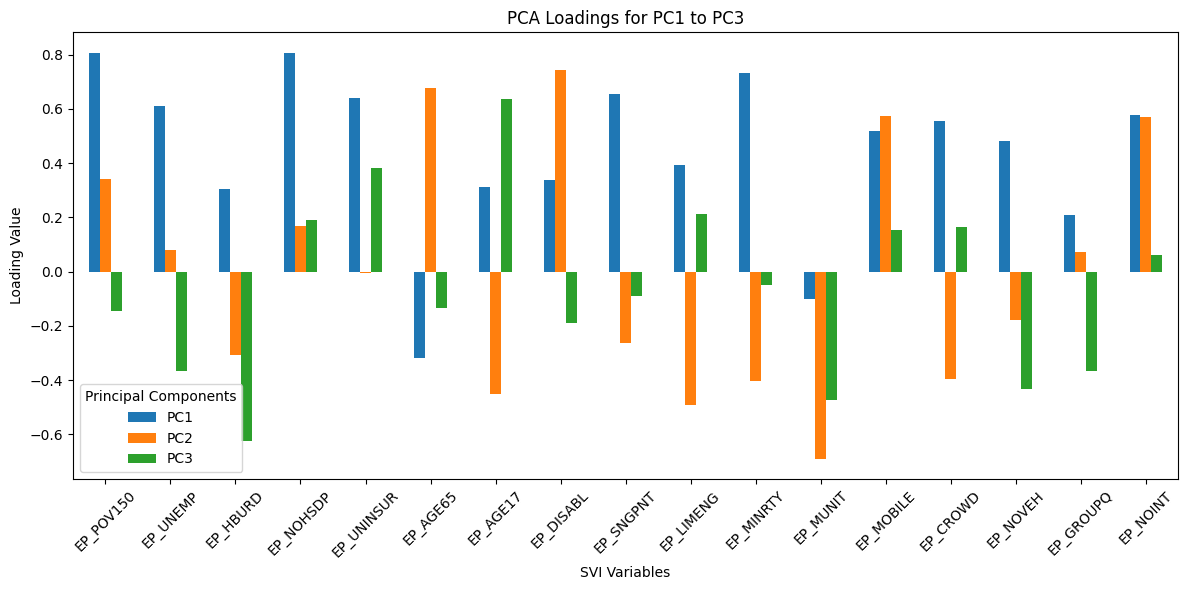

In [25]:
# Calculate the loadings matrix
# Loadings represent the correlation between the original variables and the principal components
# They are calculated by multiplying the principal components (eigenvectors) by the square root of the eigenvalues (explained variance)
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_), # Transpose components and scale
    index=SVI_VARS,                                      # Use original variable names as index
    columns=[f"PC{i+1}" for i in range(len(SVI_VARS))] # Name columns PC1, PC2, ...
)
# Select only the loadings for the first three principal components (PC1, PC2, PC3)
loadings.iloc[:, :3]

# Import the seaborn library for enhanced visualizations
import seaborn as sns
# Create a figure and axes for the heatmap
plt.figure(figsize=(10, 6))
# Generate a heatmap of the loadings for the first three PCs
# annot=True displays the loading values on the heatmap
# cmap='coolwarm' sets the color scheme (red for positive, blue for negative)
sns.heatmap(loadings.iloc[:, :3], annot=True, cmap='coolwarm')
# Set the title for the heatmap
plt.title("PCA Loadings for PC1 to PC3")
# Label the x-axis
plt.xlabel("Principal Components")
# Label the y-axis
plt.ylabel("SVI Variables")
# Display the heatmap
plt.show()

# Create a bar plot showing the loadings for each variable on the first three PCs
loadings.iloc[:, :3].plot(kind='bar', figsize=(12, 6))
# Set the title for the bar plot
plt.title("PCA Loadings for PC1 to PC3")
# Label the x-axis
plt.xlabel("SVI Variables")
# Label the y-axis
plt.ylabel("Loading Value")
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Add a legend to identify the PCs
plt.legend(title="Principal Components")
# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Display the bar plot
plt.show()

# Create a pandas DataFrame to store the PCA scores (the transformed data X_pca)
# These scores represent the coordinates of each county in the new principal component space
pca_scores = pd.DataFrame(
    X_pca,                                             # The PCA-transformed data
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], # Name columns PC1, PC2, ...
    index=svi_imputed.index                            # Use the original index from the imputed data
)

PC1: This component shows strong positive loadings for variables related to poverty (EP_POV150), lack of high school diploma (EP_NOHSDP), minority status (EP_MINRTY), unemployment (EP_UNEMP), being uninsured (EP_UNINSUR), single-parent households (EP_SNGPNT), and lack of internet access (EP_NOINT). It has negative loadings for age 65+ and multi-unit housing. Therefore, PC1 broadly represents overall socioeconomic vulnerability. Higher scores on PC1 indicate greater vulnerability related to poverty, education, employment, and minority concentration.

PC2: This component has high positive loadings for disability (EP_DISABL), age 65+ (EP_AGE65), mobile homes (EP_MOBILE), and lack of internet (EP_NOINT). It shows strong negative loadings for multi-unit housing (EP_MUNIT), limited English (EP_LIMENG), age 17 and under (EP_AGE17), and minority status (EP_MINRTY). PC2 seems to capture vulnerability related to age (elderly), disability, and specific housing types (mobile homes), contrasting with areas characterized by denser housing, younger populations, and higher proportions of minorities or limited English speakers.

PC3: This component shows positive loadings primarily for age 17 and under (EP_AGE17) and being uninsured (EP_UNINSUR). It has notable negative loadings for housing burden (EP_HBURD), multi-unit housing (EP_MUNIT), lack of vehicle access (EP_NOVEH), unemployment (EP_UNEMP), and living in group quarters (EP_GROUPQ). PC3 appears to represent a dimension contrasting areas with younger, uninsured populations against areas facing challenges related to housing costs, vehicle access, unemployment, and group living situations

## Loading Bar Plots (PC1–PC3)

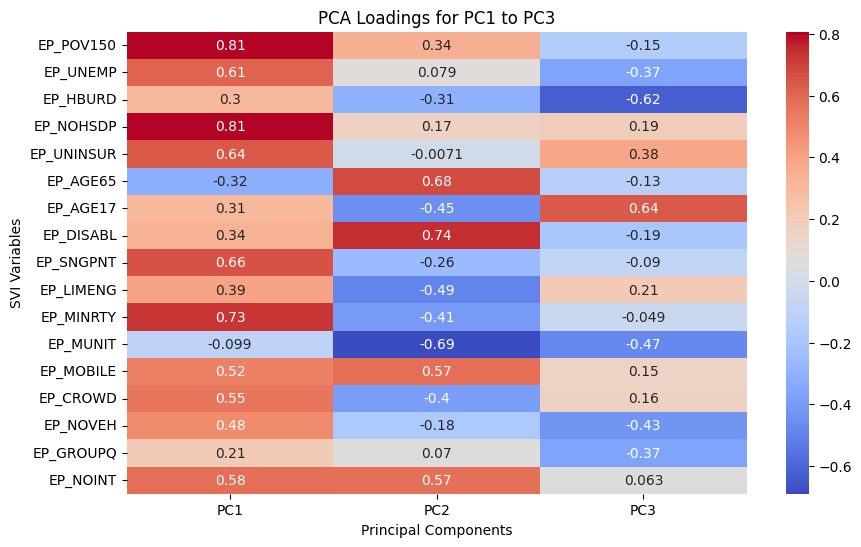

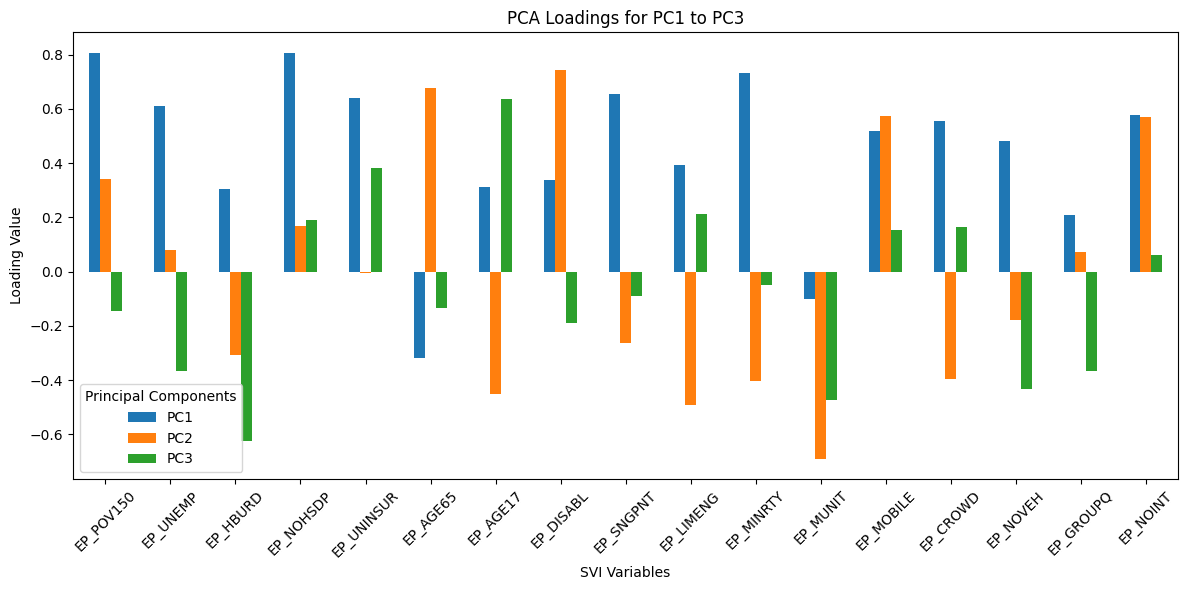

In [26]:
# Calculate the loadings matrix
# Loadings represent the correlation between the original variables and the principal components
# They are calculated by multiplying the principal components (eigenvectors) by the square root of the eigenvalues (explained variance)
loadings = pd.DataFrame(
    pca.components_.T * np.sqrt(pca.explained_variance_), # Transpose components and scale
    index=SVI_VARS,                                      # Use original variable names as index
    columns=[f"PC{i+1}" for i in range(len(SVI_VARS))] # Name columns PC1, PC2, ...
)
# Select only the loadings for the first three principal components (PC1, PC2, PC3)
loadings.iloc[:, :3]

# Import the seaborn library for enhanced visualizations
import seaborn as sns
# Create a figure and axes for the heatmap
plt.figure(figsize=(10, 6))
# Generate a heatmap of the loadings for the first three PCs
# annot=True displays the loading values on the heatmap
# cmap='coolwarm' sets the color scheme (red for positive, blue for negative)
sns.heatmap(loadings.iloc[:, :3], annot=True, cmap='coolwarm')
# Set the title for the heatmap
plt.title("PCA Loadings for PC1 to PC3")
# Label the x-axis
plt.xlabel("Principal Components")
# Label the y-axis
plt.ylabel("SVI Variables")
# Display the heatmap
plt.show()

# Create a bar plot showing the loadings for each variable on the first three PCs
loadings.iloc[:, :3].plot(kind='bar', figsize=(12, 6))
# Set the title for the bar plot
plt.title("PCA Loadings for PC1 to PC3")
# Label the x-axis
plt.xlabel("SVI Variables")
# Label the y-axis
plt.ylabel("Loading Value")
# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
# Add a legend to identify the PCs
plt.legend(title="Principal Components")
# Adjust layout to prevent labels from overlapping
plt.tight_layout()
# Display the bar plot
plt.show()

# Create a pandas DataFrame to store the PCA scores (the transformed data X_pca)
# These scores represent the coordinates of each county in the new principal component space
pca_scores = pd.DataFrame(
    X_pca,                                             # The PCA-transformed data
    columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], # Name columns PC1, PC2, ...
    index=svi_imputed.index                            # Use the original index from the imputed data
)

## PCA Scores

In [27]:
# Combine the identifier columns (if any) with the PCA scores into a single DataFrame for easier interpretation
scores = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
if ID_COLS:
    scores = pd.concat([svi_clean[ID_COLS].reset_index(drop=True),
                        scores.reset_index(drop=True)], axis=1)
scores.head()


,FIPS,STATE_x,COUNTY_x,NRI_ID,PC1,PC2,PC3,PC4,PC5,PC6,...,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,1001,Alabama,Autauga,C01001,-0.991040,-0.366071,0.831220,-0.481993,0.684692,0.382104,...,-0.338145,0.559996,0.299080,-0.402265,-0.422682,-0.027112,0.674901,0.188306,0.233642,-0.365447
1,1003,Alabama,Baldwin,C01003,-1.776816,-1.025103,-0.400895,0.350233,-0.460791,0.687855,...,0.251372,0.995051,0.440398,0.228677,-0.346596,-0.727630,-0.426702,0.102187,0.381530,0.616440
2,1005,Alabama,Barbour,C01005,4.461214,1.217623,-0.971670,0.754672,1.304562,-0.677016,...,-0.320425,-0.571393,0.771682,-1.350473,0.197429,0.481362,-0.273041,-0.109384,0.239005,0.469984
3,1007,Alabama,Bibb,C01007,2.113931,1.449988,-0.656709,-0.226219,1.074960,0.182073,...,-0.771856,0.739517,0.603102,0.239387,-0.048502,0.786191,-0.018834,-0.262679,0.270996,0.498634
4,1009,Alabama,Blount,C01009,0.578184,0.804139,1.149731,-0.087876,-0.037695,0.334674,...,-0.666143,0.639299,0.210763,0.128381,-0.040899,0.705282,-0.172765,-0.351656,0.131431,0.183733


## Make Map of PC1 Scores by County

Loading county shapefile...
Shapefile loaded.


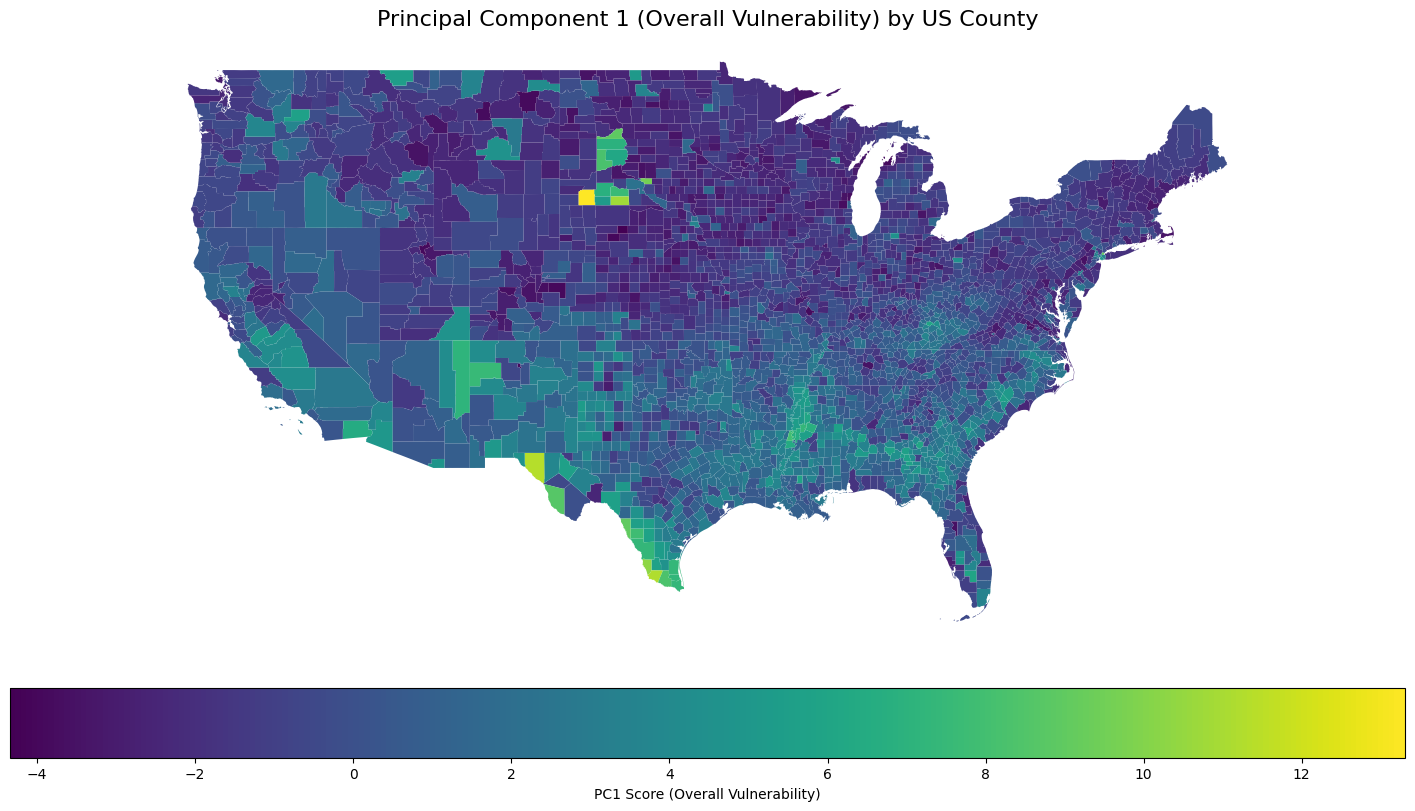

In [28]:
# Import the geopandas library for working with geospatial data
import geopandas as gpd
# Import matplotlib.pyplot again (though already imported, common practice in notebooks)
import matplotlib.pyplot as plt
# Import ssl (used here likely to handle potential SSL certificate issues when downloading shapefiles, though the file is local)
import ssl

# Print status message
print("Loading county shapefile...")
# Read the US county boundaries shapefile into a GeoDataFrame
# It reads from a zip file containing the shapefile components (.shp, .dbf, .shx, etc.)
gdf_counties = gpd.read_file("/Users/keith/Documents/code/Intro to ML 2025/data/raw/cb_2022_us_county_5m.zip")
# Print status message
print("Shapefile loaded.")


# Create a copy of the PCA scores DataFrame for mapping purposes
scores_map = scores.copy()
# Convert the 'FIPS' column to string type and pad with leading zeros to ensure a consistent 5-digit format (e.g., '1001' becomes '01001')
scores_map['FIPS'] = scores_map['FIPS'].astype(str).str.zfill(5)

# Add a 'FIPS' column to the county GeoDataFrame, copying the values from the 'GEOID' column which typically holds the FIPS code
gdf_counties['FIPS'] = gdf_counties['GEOID']

# Merge the county GeoDataFrame with the PCA scores DataFrame based on the common 'FIPS' column
# 'how='left'' ensures all counties from the shapefile are kept; scores are added where FIPS codes match
merged_gdf = gdf_counties.merge(scores_map, on='FIPS', how='left')

# Filter the merged GeoDataFrame to include only the Continental US (CONUS)
# It removes rows where the 'STATEFP' (state FIPS code) corresponds to Alaska ('02'), Hawaii ('15'),
# or US territories (like '60' American Samoa, '66' Guam, '69' N. Mariana Islands, '72' Puerto Rico, '78' US Virgin Islands)
conus_gdf = merged_gdf[~merged_gdf['STATEFP'].isin([
    '02', '15', '60', '66', '69', '72', '78'
])]

# Create a figure and a single subplot (axes) for the map, specifying the figure size
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

# Plot the CONUS GeoDataFrame as a choropleth map
conus_gdf.plot(
    column='PC1',       # Specify the column ('PC1' scores) to use for coloring the counties
    ax=ax,              # Tell geopandas to plot on the created axes 'ax'
    legend=True,        # Display a color legend (colorbar)
    legend_kwds={       # Customize the legend appearance
        'label': "PC1 Score (Overall Vulnerability)", # Label for the colorbar
        'orientation': "horizontal",                  # Set legend orientation
        'pad': 0.05                                   # Padding around the legend
    },
    cmap='viridis',     # Set the colormap for coloring (viridis is perceptually uniform)
    missing_kwds={      # Define how to style counties with missing PC1 data (due to merge issues or original missing data)
        'color': 'lightgrey', # Color for missing data counties
        'edgecolor': 'none',  # No border for missing data counties
        'hatch': '///',       # Use hatching pattern for missing data
        'label': 'Missing data' # Label for missing data in the legend (if applicable, though often doesn't show with colorbar)
    }
)

# Set the title for the map
ax.set_title('Principal Component 1 (Overall Vulnerability) by US County', fontsize=16)
# Turn off the coordinate axes (latitude/longitude lines and labels)
ax.set_axis_off()
# Display the map
plt.show()

Higher Vulnerability: These areas are clustered in the Southeast, particularly in Appalachia, the Mississippi Delta region, and other parts of the Deep South. High vulnerability is also evident in parts of the Southwest, especially along the U.S.-Mexico border and in areas corresponding to Native American reservations. Scattered high-vulnerability counties also appear in some rural areas of the Midwest and West.

Lower Vulnerability: These areas are more concentrated in the Northeast, the Upper Midwest (around the Great Lakes), and parts of the West, including Colorado, Utah, and areas in the Pacific Northwest. Many suburban counties and more affluent rural regions also exhibit lower PC1 scores.

Overall, the map highlights significant regional disparities in socioeconomic vulnerability as captured by the primary dimension derived from the SVI variables.